In [4]:
import torch
import scipy.stats as stats
import numpy as np

# Creating Data

In [5]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step)
X[:10]

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800])

In [6]:
X = X.unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

With Random Data

In [7]:
# Noise
np.random.seed(seed=1234) # setting seed for stats, which uses numpy
n = 30
df = n - 1
random_noise = torch.tensor(stats.t.rvs(df, loc=0, scale=0.1, size=X.shape[0])).unsqueeze(dim=1)
y_random = weight * X + random_noise
y_random[:10]

tensor([[0.0564],
        [0.0754],
        [0.1229],
        [0.0121],
        [0.1585],
        [0.0805],
        [0.1235],
        [0.0299],
        [0.1302],
        [0.0675]], dtype=torch.float64)

In [8]:
weight*X[1,0]+random_noise[1,0] # All working as expected

tensor(0.0754, dtype=torch.float64)

# Simpliting Data

In [9]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train, y_train_random = X[:train_split], y[:train_split], y_random[:train_split]

X_test, y_test, y_test_random = X[train_split:], y[train_split:], y_random[train_split:]

len(X_train), len(y_train), len(y_train_random), len(X_test), len(y_test), len(y_test_random)

(40, 40, 40, 10, 10, 10)

# Plotting Data

In [10]:
import matplotlib.pyplot as plt

def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=16, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=16, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=16, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

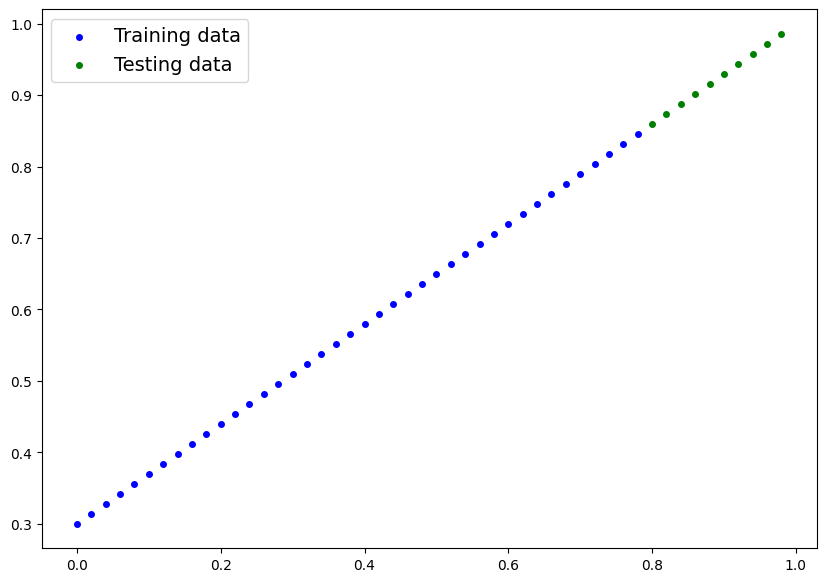

In [11]:
# for deterministic data
plot_predictions();

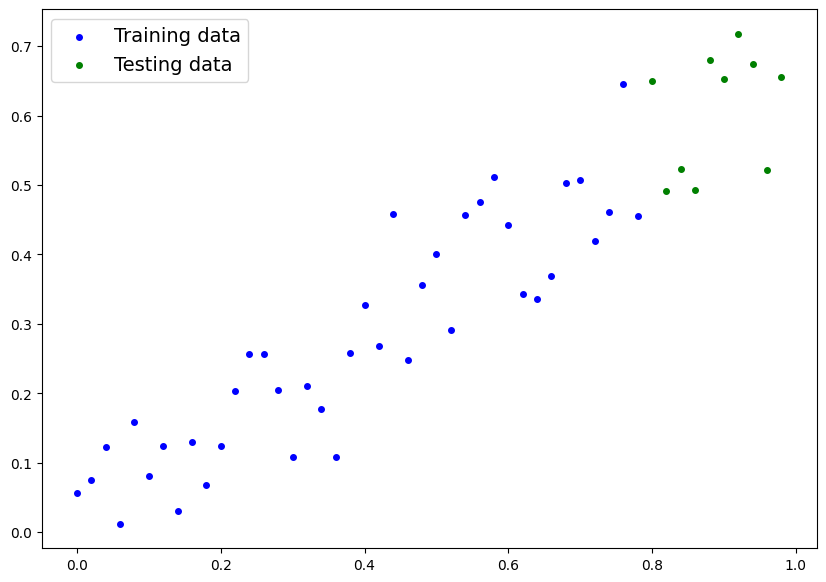

In [12]:
# for aleatoric data
plot_predictions(train_labels=y_train_random,test_labels=y_test_random);

# Creating the Model

In [13]:
from torch import nn

In [91]:
# Create a Linear Regression model class
class LRModel(nn.Module): 
# our model must inherit several fundamental behaviours from nn.Module
# The base class which all custom user created models must subclass.
    def __init__(self):
        super().__init__() # running __init__ method of super class
        self.weight = nn.Parameter(
            torch.randn(1, dtype=torch.float),
            # start with random weights (model learning will adjust these)
            requires_grad=True) # telling torch to update these values.

        self.bias = nn.Parameter(
            torch.randn(1,dtype=torch.float), # starting with random bias.
            requires_grad=True) # telling torch to update these values, when optimizing

    # Forward defines the output of the model, i.e. model(x) is defined here.
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is the input (torch.Size([10, 1])). see above prints and below
        print(x.shape)
        return self.weight * x + self.bias 
        # this is the linear regression formula (y = m*x + b)

In [92]:
torch.manual_seed(42)
# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

In [93]:
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# Checking the Model Structure

In [94]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (untrained)
model_0 = LRModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [95]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [96]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

torch.Size([10, 1])


`torch.inference_mode()` turns off a many unnecessary properties (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the `forward()` method) faster.

## Plotting predictions

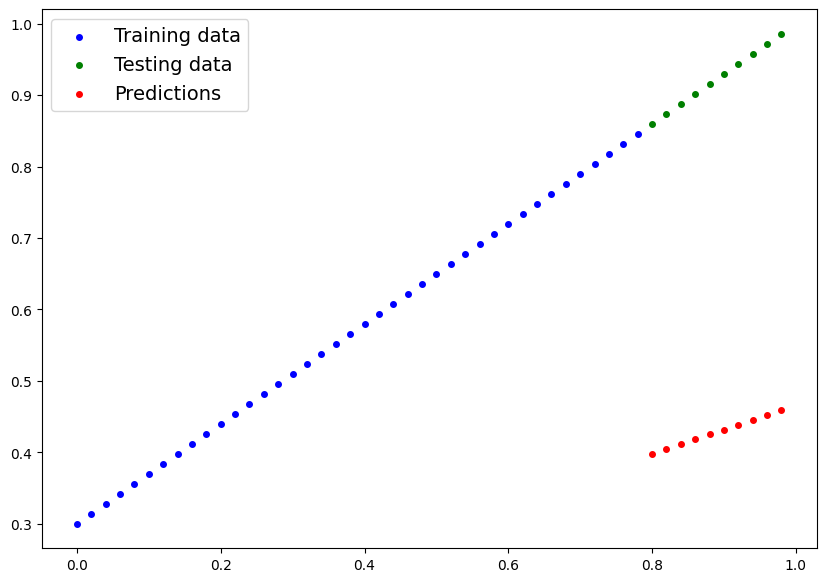

In [97]:
# for deterministic data
plot_predictions(predictions=y_preds);

# Training The Model

## Defining a loss function and optimization algorithm

In [98]:
mse_loss = nn.MSELoss()

optimizer = torch.optim.SGD(
    params = model_0.parameters(), # model parameters to be optimized
    lr=0.01
)

### Defining Train Loop

In [20]:
def train_loop(
        input: torch.Tensor, labels: torch.Tensor,
        model: nn.Module, loss_fn:nn.modules.loss._Loss,
        optimizer: torch.optim.Optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    # Forward pass on train data using the forward() method 
    pred = model(input)
    loss = loss_fn(pred, labels)
    # Backpropagation
    loss.backward()
    # optimize parameters
    optimizer.step()
    # restart cycle
    optimizer.zero_grad()
    return loss


### Defining Test Loop

In [21]:
def test_loop(
        input: torch.Tensor, labels: torch.Tensor,
        model: nn.Module, loss_fn:nn.modules.loss._Loss):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    with torch.inference_mode():
        pred = model(input)
        loss = loss_fn(pred, labels)
    return loss


## Executing the training and testing.

In [55]:
torch.manual_seed(42)
# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epochs_range = range(epochs)

### With Deterministic Data

In [56]:
for epoch in epochs_range:
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_loop(input = X_train, labels = y_train, 
                            model = model_0, loss_fn = mse_loss, optimizer = optimizer)
    train_loss_values.append(train_loss.detach().numpy())
    test_loss = test_loop(input = X_train, labels = y_train, 
                            model = model_0, loss_fn = mse_loss)
    test_loss_values.append(test_loss.detach().numpy())
    print(f"MSE Train Loss: {train_loss} | MSE Test Loss: {test_loss} ")
print("Done!")

Epoch 1
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.000637702876701951 | MSE Test Loss: 0.0006365308654494584 
Epoch 2
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.0006365308654494584 | MSE Test Loss: 0.0006353610078804195 
Epoch 3
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.0006353610078804195 | MSE Test Loss: 0.000634192896541208 
Epoch 4
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.000634192896541208 | MSE Test Loss: 0.0006330275209620595 
Epoch 5
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.0006330275209620595 | MSE Test Loss: 0.0006318636005744338 
Epoch 6
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.0006318636005744338 | MSE Test Loss: 0.0006307019502855837 
Epoch 7
-------------------------------
torch.Size([40,

In [57]:
len(train_loss_values) == len(train_loss_values)

True

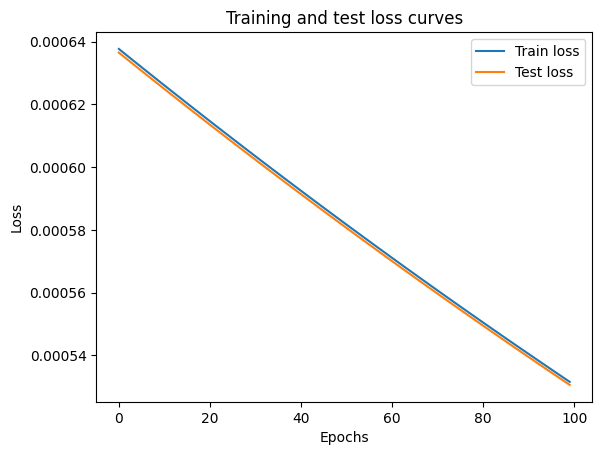

In [58]:
# Plot the loss curves
plt.plot(list(epochs_range), train_loss_values, label="Train loss")
plt.plot(list(epochs_range), test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [60]:
list(model_0.parameters()), model_0.state_dict()

([Parameter containing:
  tensor([0.6006], requires_grad=True),
  Parameter containing:
  tensor([0.3407], requires_grad=True)],
 OrderedDict([('weight', tensor([0.6006])), ('bias', tensor([0.3407]))]))

In [61]:
weight, bias

(0.7, 0.3)

In [62]:
def predict(
        input: torch.Tensor, model: nn.Module) -> torch.Tensor:
    model.eval()
    with torch.inference_mode():
        # 3. Make sure the calculations are done with the model and data on the same device
        # model_0.to(device)
        # X_test = X_test.to(device)
        pred = model(input)
    return pred

torch.Size([10, 1])


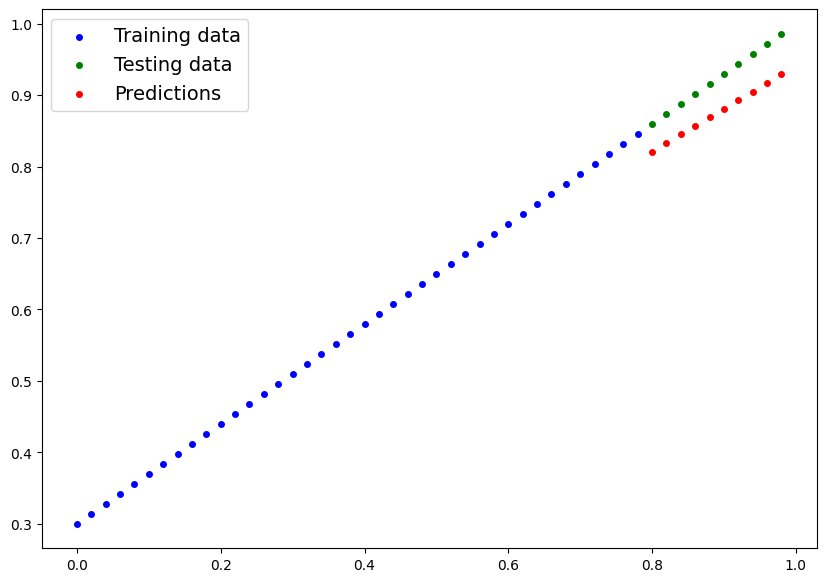

In [63]:
plot_predictions(predictions=predict(model= model_0, input = X_test))

# Consolidating everything!

In [99]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): 
# our model must inherit several fundamental behaviours from nn.Module
# The base class which all custom user created models must subclass.
    def __init__(self):
        super().__init__() # running __init__ method of super class
        self.weight = nn.Parameter(
            torch.randn(1, dtype=torch.float),
            # start with random weights (model learning will adjust these)
            requires_grad=True) # telling torch to update these values.

        self.bias = nn.Parameter(
            torch.randn(1,dtype=torch.float), # starting with random bias.
            requires_grad=True) # telling torch to update these values, when optimizing
        self.train_loss_values = []
        self.test_loss_values = []

    # Forward defines the output of the model, i.e. model(x) is defined here.
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is the input (torch.Size([10, 1])). see above prints and below
        print(x.shape)
        return self.weight * x + self.bias 
        # this is the linear regression formula (y = m*x + b)
    
    def _train_loop_(self,
        input: torch.Tensor, labels: torch.Tensor,
        loss_fn:nn.modules.loss._Loss,
        optimizer: torch.optim.Optimizer):
        # Set the model to training mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        self.train()
        # Forward pass on train data using the forward() method 
        pred = self(input)
        loss = loss_fn(pred, labels)
        # Backpropagation
        loss.backward()
        # optimize parameters
        optimizer.step()
        # restart cycle
        optimizer.zero_grad()
        return loss

    def _test_loop_(self, input: torch.Tensor, labels: torch.Tensor, 
                  loss_fn:nn.modules.loss._Loss):
        # Set the model to evaluation mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        self.eval()
        with torch.inference_mode():
            pred = self(input)
            loss = loss_fn(pred, labels)
        return loss

    def train_model(self, input: torch.Tensor, labels: torch.Tensor,
                    loss_fn:nn.modules.loss._Loss, optimizer: torch.optim.Optimizer):
        for epoch in epochs_range:
            print(f"Epoch {epoch+1}\n-------------------------------")
            train_loss = self._train_loop_(input = input, labels = labels, 
                                         loss_fn = loss_fn, optimizer = optimizer)
            self.train_loss_values.append(train_loss.detach().numpy())
            test_loss = self._test_loop_(input = input, labels = labels, 
                                       loss_fn = loss_fn)
            self.test_loss_values.append(test_loss.detach().numpy())
            print(f"MSE Train Loss: {train_loss} | MSE Test Loss: {test_loss} ")
        print("Done!")

    def predict(self, input: torch.Tensor) -> torch.Tensor:
        self.eval()
        with torch.inference_mode():
            # 3. Make sure the calculations are done with the model and data on the same device
            # model_0.to(device)
            # X_test = X_test.to(device)
            pred = self(input)
        return pred

In [108]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)
model_1 = LinearRegressionModel()
# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_1.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [109]:
mse_loss = nn.MSELoss()

optimizer_1 = torch.optim.SGD(
    params = model_1.parameters(), 
    # if we don't do this, we won't optimize model_1 parameters, but reference model_0
    lr=0.01
)
model_1.train_model(input= X_train, labels=y_train, loss_fn=mse_loss, optimizer=optimizer_1)

Epoch 1
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.10493002086877823 | MSE Test Loss: 0.10026919841766357 
Epoch 2
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.10026919841766357 | MSE Test Loss: 0.09582177549600601 
Epoch 3
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.09582177549600601 | MSE Test Loss: 0.0915779322385788 
Epoch 4
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.0915779322385788 | MSE Test Loss: 0.08752834796905518 
Epoch 5
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.08752834796905518 | MSE Test Loss: 0.08366413414478302 
Epoch 6
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1])
MSE Train Loss: 0.08366413414478302 | MSE Test Loss: 0.07997677475214005 
Epoch 7
-------------------------------
torch.Size([40, 1])
torch.Size([40, 1]

In [110]:
list(model_1.parameters())

[Parameter containing:
 tensor([0.4600], requires_grad=True),
 Parameter containing:
 tensor([0.3675], requires_grad=True)]

torch.Size([10, 1])


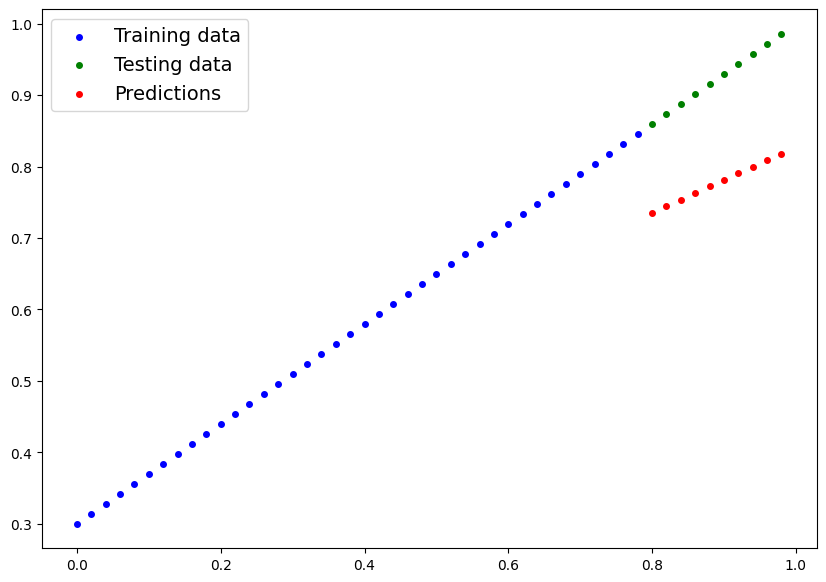

In [111]:
plot_predictions(predictions=model_1.predict(input = X_test))

# Saving The Model